# Using Microsoft AI to Build a Lung-Disease Prediction Model Using Chest X-Ray Images - Tutorial

## Introduction 

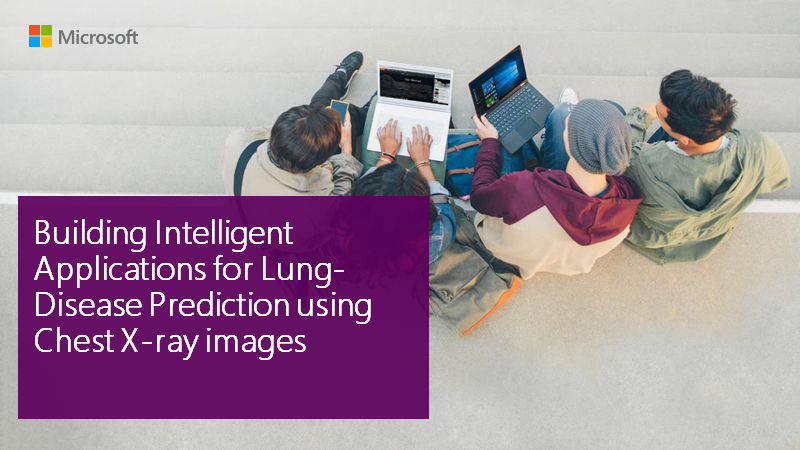

# Pneumonia and other lung diseases are lethal!

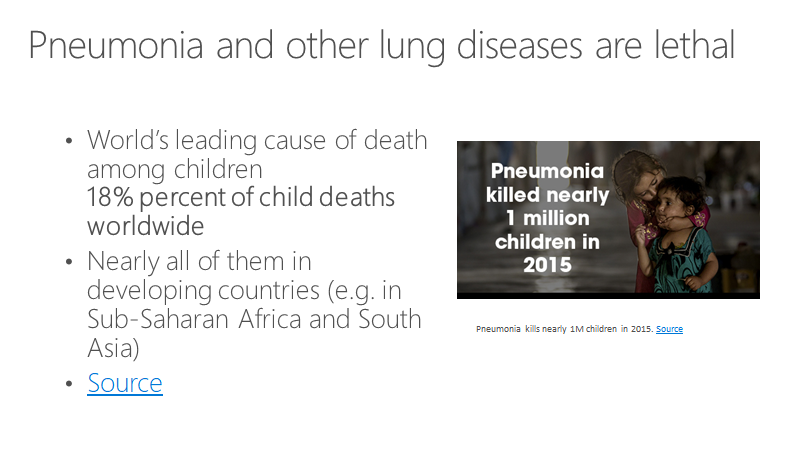

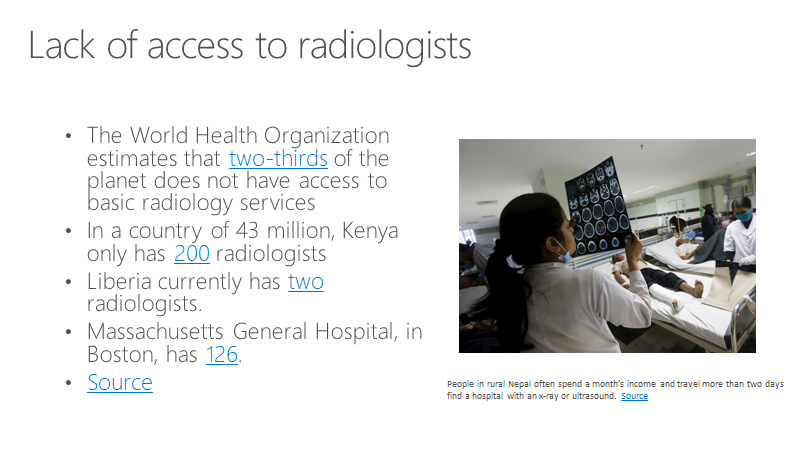

# How can AI Help?

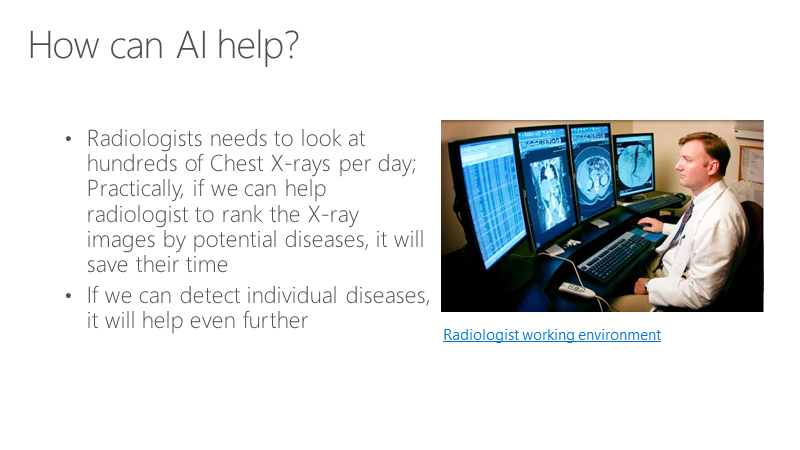

This Jupyter Notebook is the tutorial to walk people through how to build a lung-dissease prediction model using Chest X-ray Images. The full code is in this github repo (https://github.com/Azure/AzureChestXRay) and the blogpost is here (https://blogs.technet.microsoft.com/machinelearning/2018/03/07/using-microsoft-ai-to-build-a-lung-disease-prediction-model-using-chest-x-ray-images/)

This tutorial consists of a few parts:
- Build a lung disease prediction model
- Validate model and get metrics
- Visulaizing the model result

Here are all the resources that are used in this 
- _Dataset_

  - National Institutes of Health ( [NIH](https://www.nih.gov/)) chest x-ray dataset. This dataset is a  [publicly](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)  [available](https://nihcc.app.box.com/v/ChestXray-NIHCC) and medically  [curated](http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) dataset.

- _Technique_

  - State-of-the art  [DenseNet](https://arxiv.org/pdf/1608.06993.pdf) for image classification. DenseNet is an open-source deep learning algorithm with implementations available in  [Keras](https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/applications/densenet.py) (using  [TensorFlow](https://www.tensorflow.org/) as a back-end). We also explored the  [PyTorch](http://pytorch.org/) version of DenseNet.

  - [Class Activation Maps](http://cnnlocalization.csail.mit.edu/) are used to understand model activation and visualize it.

- _Tools and Platforms_

  - [Deep Learning VMs with GPU acceleration](https://docs.microsoft.com/en-us/azure/machine-learning/data-science-virtual-machine/deep-learning-dsvm-overview) are used as the compute environment.

  - [Azure Machine Learning](https://azure.microsoft.com/en-us/services/machine-learning-services/) is used as a managed machine learning service for project management, run history and version control, and model deployment.


The  [source code we provide on GitHub](https://github.com/Azure/AzureChestXRay) allows you to build the x-ray image pathology classification system in less than an hour using the model pretrained on ChestX-ray14 data. If needed, one can also recreate and expand the full multi-GPU training pipeline starting with a model pretrained using the  [ImageNet](http://image-net.org/) dataset.

The source code, tools, and discussion below are provided to assist data scientists in understanding the potential for developing deep learning -driven intelligent applications using Azure AI services and are intended for research and development use only. The x-ray image pathology classification system is not intended for use in clinical diagnosis or clinical decision-making or for any other clinical use. The performance of this model for clinical use has not been established.

# Downloading packages & create folders
We will install a few packages that will be required later on. We will also download a small portion of data (1% of the original dataset) for tutorial purpose.

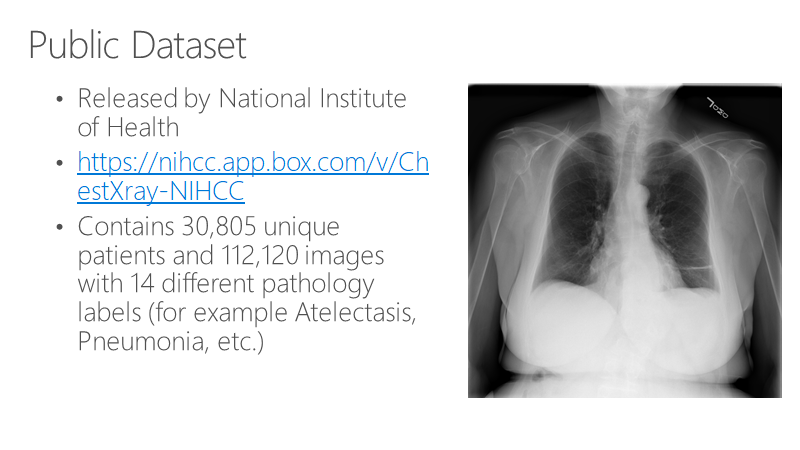

In [1]:
import os
import re
import timeit

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import cv2
import keras
import tensorflow as tf
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)
from keras.backend.tensorflow_backend import set_session
config=tf.ConfigProto(inter_op_parallelism_threads=2, intra_op_parallelism_threads=2)
set_session(tf.Session(config=config))

import keras.backend as K
import numpy as np
import pandas as pd
import tqdm
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import Sequence
from keras_contrib.applications.densenet import DenseNetImageNet121
from tensorflow.python.client import device_lib
import onnxmltools
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras version: 2.2.0
TensorFlow version: 1.8.0


In [2]:

import getpass
username = getpass.getuser()
data_path = "/usr/local/share/xraytutorial"
output_path = os.path.join("/mnt","xraytutorial", username)
print("root folder for all the output would be", output_path, ", input would be", data_path)
pathlib.Path(data_path).mkdir(parents=True, exist_ok=True) 
pathlib.Path(output_path).mkdir(parents=True, exist_ok=True) 


images_path = os.path.join(data_path, 'images.zip')
images_extracted_path = os.path.join(data_path, 'images')
pre_trained_model_path = os.path.join(data_path, 'chexray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5')
label_path = os.path.join(data_path, 'Data_Entry_2017.csv')

# global variables
tensorboard_dir = os.path.join(output_path, 'tensorboard')
weights_dir = os.path.join(output_path, 'modelweights')
pathlib.Path(weights_dir).mkdir(parents=True, exist_ok=True) 
weights_file = os.path.join(weights_dir, 'chexnet_14_weights_712split_epoch_{epoch:03d}_val_loss_{val_loss:.4f}_withoutDenseLayers.hdf5')


#onnx model path
onnx_model_save_path = os.path.join(data_path, 'chestxray.onnx')

root folder for all the output would be /mnt/xraytutorial/xiaoyzhu , input would be /usr/local/share/xraytutorial


In [10]:
resized_height = 224
resized_width = 224

name_list = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
             'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


# Dataset introduction and download sample data
We use a weakly labelled dataset that was released by the NIH a few months ago. The dataset is described in  [this paper](https://arxiv.org/abs/1705.02315), and you can download it from  [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). It includes over 30,805 unique patients and 112,120 frontal-view X-ray images with 14 different pathology labels (e.g. atelectasis, pneumonia, etc.) mined from radiology reports using NLP methods such as keyword search and semantic data integration. The NIH-released data also has 983 hand-labelled images covering 8 pathologies, which can be considered as strong labels. We train our model excluding those human labelled data and will use them for later visualization.

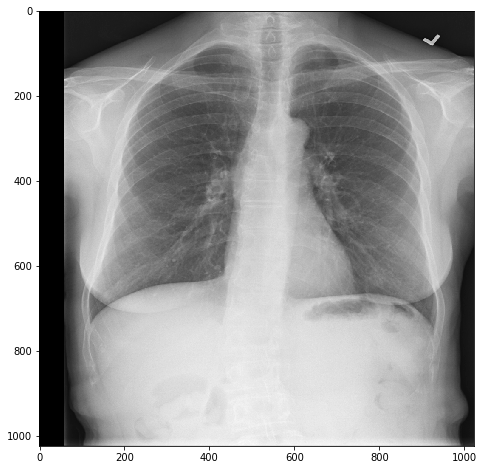

In [4]:

img = mpimg.imread(os.path.join(data_path, 'images','00000700_000.png'))
plt.figure(figsize=(8,8))
imgplot = plt.imshow(img, cmap='gray')

# Network Architecture (DenseNet)

Deep neural networks are notoriously hard to train well, especially when the neural networks get deeper. Inspired by the  [Stanford team](https://stanfordmlgroup.github.io/projects/chexnet/), we use the [DenseNet](https://arxiv.org/abs/1608.06993)-121 architecture with pre-trained weights from ImageNet as initialization parameters. This allows us to both pass the gradient more efficiently and train a deeper model. This architecture alleviates the vanishing-gradient problem and enables feature map reuse, which makes it possible to train very deep neural networks.

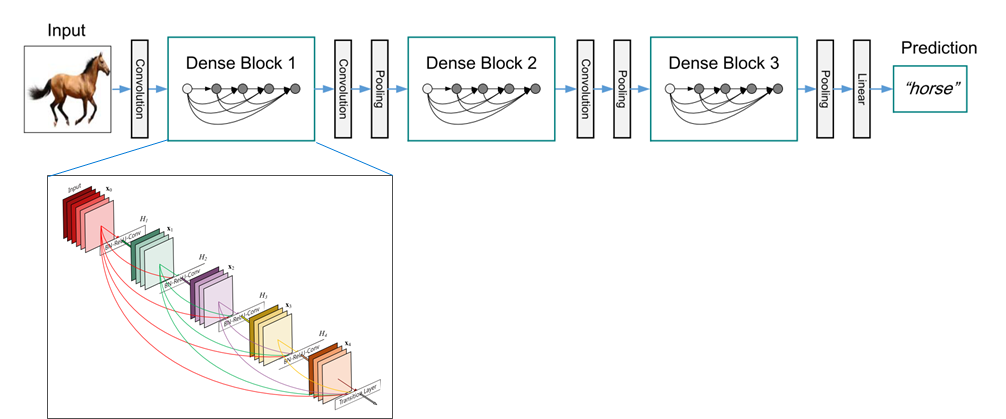

We will  use 100 patients for testing purpose, which is around 1% of the total dataset.

In [5]:
def build_model():
    """

    Returns: a model with specified weights

    """
    # define the model, use pre-trained weights for image_net
    base_model = DenseNetImageNet121(input_shape=(resized_height, resized_width, num_channel),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='avg')

    x = base_model.output
    x = Dense(100, activation='relu')(x)
    predictions = Dense(14, activation='sigmoid', name="final_classifier")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


# loss function
def unweighted_binary_crossentropy(y_true, y_pred):
    """
    Args:
        y_true: true labels
        y_pred: predicted labels

    Returns: the sum of binary cross entropy loss across all the classes

    """
    return K.sum(K.binary_crossentropy(y_true, y_pred))


# Visualizing the models (Class Activation Mapping)

Individual prediction activation maps like Class Activation Mapping ( [CAM](http://cnnlocalization.csail.mit.edu/)) images allow one to understand what the model learns and thus explain a prediction/score. CAM methods are useful to help understand and explain model predictions. Aside from explaining model output, CAM images can also be used for model improvement through guided training. For example, one can modify the training data by removing (or relabeling) areas in the image that should not be the focus for prediction.

We use CAM visualization to understand how to interpret the classification results for new chest X-ray images. The cardiomegaly pathology bounding box from the NIH annotated data and peak CAM image show a good visual overlap, indicating that the model focuses on the right area of the image when issuing the prediction.


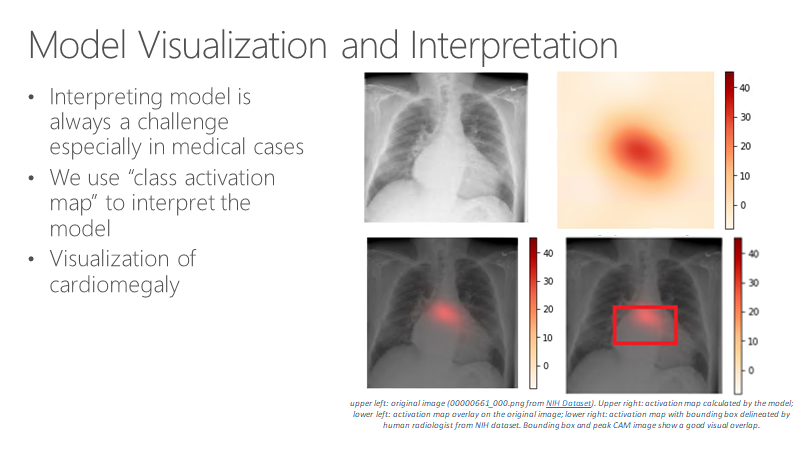

In [6]:
print("loading pre-trained model from path:",pre_trained_model_path)
#    model = load_model(current_model_file)
model = keras.models.load_model(pre_trained_model_path)

model.summary()
# replace mode weights with the ones computing by training in chest xray


loading pre-trained model from path: /usr/local/share/xraytutorial/chexray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5


/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
initial_bn (BatchNormalization) (None, 112, 112, 64) 256         initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           initial_bn[0][0]                 
__________________________________________________________________________________________________
max_poolin

dense_3_0_bottleneck_bn (BatchN (None, 7, 7, 128)    512         dense_3_0_bottleneck_conv2D[0][0]
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 7, 7, 128)    0           dense_3_0_bottleneck_bn[0][0]    
__________________________________________________________________________________________________
dense_3_0_conv2D (Conv2D)       (None, 7, 7, 32)     36864       activation_90[0][0]              
__________________________________________________________________________________________________
concatenate_43 (Concatenate)    (None, 7, 7, 544)    0           average_pooling2d_3[0][0]        
                                                                 dense_3_0_conv2D[0][0]           
__________________________________________________________________________________________________
dense_3_1_bn (BatchNormalizatio (None, 7, 7, 544)    2176        concatenate_43[0][0]             
__________

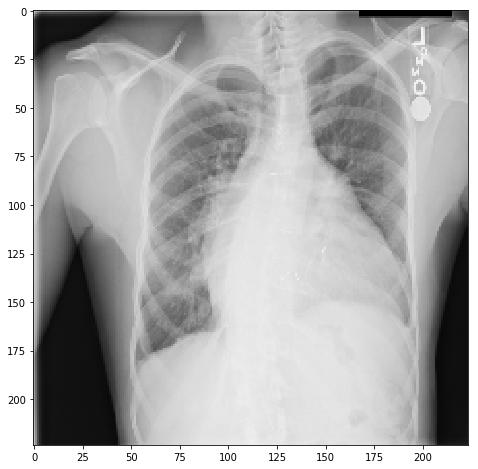

In [7]:
# get diseases prediction and feature maps used for cam just as FYI
#  a cam image is class_weights[:, some_pathology]*conv_features[:,:,i]

from keras.models import Model
test_image_path = os.path.join(data_path, 'images','00000728_000.png') #.png 



cv2_image = cv2.resize(cv2.imread(test_image_path), (resized_height, resized_width))
predictions = model.predict(cv2_image[None,:,:,:])
predictions
conv_map_model = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
conv_features = conv_map_model.predict(cv2_image[None,:,:,:])
conv_features = conv_features[0, :, :, :] #np.squeeze(conv_features)
class_weights = model.layers[-1].get_weights()

plt.figure(figsize=(8,8))
imgplot = plt.imshow(cv2_image, cmap='gray')

In [8]:
def get_score_and_cam_picture(cv2_input_image, DenseNetImageNet121_model):
# based on https://github.com/jacobgil/keras-cam/blob/master/cam.py
    width, height, _ = cv2_input_image.shape
    class_weights = DenseNetImageNet121_model.layers[-1].get_weights()[0]
    final_conv_layer = DenseNetImageNet121_model.layers[-3]
    get_output = K.function([DenseNetImageNet121_model.layers[0].input], 
                            [final_conv_layer.output, \
                             DenseNetImageNet121_model.layers[-1].output])
    [conv_outputs, prediction] = get_output([cv2_input_image[None,:,:,:]])
    conv_outputs = conv_outputs[0, :, :, :]
    prediction = prediction[0,:]
    
    #Create the class activation map.
    predicted_disease = np.argmax(prediction)
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[:2])
    for i, w in enumerate(class_weights[:, predicted_disease]):
            cam += w * conv_outputs[:, :, i]
    
    return prediction, cam, predicted_disease


def process_cam_image(crt_cam_image, xray_image, crt_alpha = .5):
    im_width, im_height, _ = xray_image.shape
    crt_cam_image = cv2.resize(crt_cam_image, (im_width, im_height), \
                               interpolation=cv2.INTER_CUBIC)
    
#     do some gamma enhancement, e is too much
    crt_cam_image = np.power(1.1, crt_cam_image)
    crt_cam_image = normalize_nd_array(crt_cam_image)
    # crt_cam_image[np.where(crt_cam_image < 0.5)] = 0 
    crt_cam_image = 255*crt_cam_image

    # make cam an rgb image
    empty_image_channel = np.zeros(dtype = np.float32, shape = crt_cam_image.shape[:2])
    crt_cam_image = cv2.merge((crt_cam_image,empty_image_channel,empty_image_channel))
    
    blended_image = cv2.addWeighted(xray_image.astype('uint8'),crt_alpha,\
                                    crt_cam_image.astype('uint8'),(1-crt_alpha),0)
    return(blended_image)

def plot_cam_results(crt_blended_image, crt_cam_image, crt_xray_image, map_caption):
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize = (15,7))

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(crt_xray_image, cmap = 'gray', interpolation = 'bicubic')
    ax1.set_title('Orig X Ray')
    plt.axis('off')

    ax2 = fig.add_subplot(2,3, 2)
    cam_plot = ax2.imshow(crt_cam_image, cmap=plt.get_cmap('OrRd'), interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax2)
    ax2.set_title('Activation Map')
    plt.axis('off')

    ax3 = fig.add_subplot(2,3, 3)
    blended_plot = ax3.imshow(crt_blended_image, interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax3)
    ax3.set_title(map_caption)
    plt.axis('off')
    
    # serialize blended image plot padded in the x/y-direction
    import io
    image_as_BytesIO = io.BytesIO()
    x_direction_pad = 1.05;y_direction_pad=1.2
    extent = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(image_as_BytesIO, 
                bbox_inches=extent.expanded(x_direction_pad, 
                                            y_direction_pad),
               format='png')
    image_as_BytesIO.seek(0)
    return(image_as_BytesIO)
    

    
def process_xray_image(crt_xray_image, DenseNetImageNet121_model):
    crt_xray_image = normalize_nd_array(crt_xray_image)
    crt_xray_image = 255*crt_xray_image
    crt_xray_image=crt_xray_image.astype('uint8')

    crt_predictions, crt_cam_image, predicted_disease_index = \
    get_score_and_cam_picture(crt_xray_image, 
                              DenseNetImageNet121_model)
    
    prj_consts = chestxray_consts()
    likely_disease=name_list[predicted_disease_index]
    likely_disease_prob = 100*crt_predictions[predicted_disease_index]
    likely_disease_prob_ratio=100*crt_predictions[predicted_disease_index]/sum(crt_predictions)
    print('predictions: ', crt_predictions)
    print('likely disease: ', likely_disease)
    print('likely disease prob: ', likely_disease_prob)
    print('likely disease prob ratio: ', likely_disease_prob_ratio)
    
    crt_blended_image = process_cam_image(crt_cam_image, crt_xray_image)
    plot_cam_results(crt_blended_image, crt_cam_image, crt_xray_image,
                    str(likely_disease)+ ' ' +
                    "{0:.1f}".format(likely_disease_prob)+ '% (weight ' +
                    "{0:.1f}".format(likely_disease_prob_ratio)+ '%)')
      

def normalize_nd_array(crt_array):
    # Normalised [0,1]
    crt_array = crt_array - np.min(crt_array)
    return(crt_array/np.ptp(crt_array))

likely disease:  Cardiomegaly
likely disease prob ratio:  0.7359209110588707


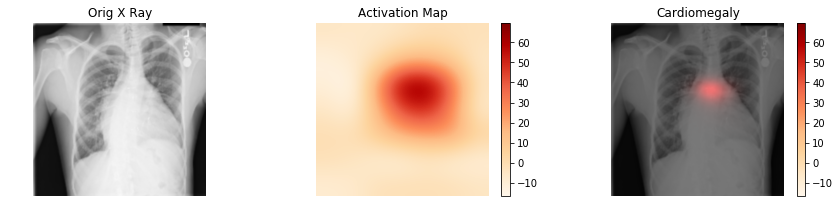

In [11]:
# get diseases prediction and cam


cv2_image = normalize_nd_array(cv2_image)
cv2_image = 255*cv2_image
cv2_image=cv2_image.astype('uint8')

predictions, cam_image, predicted_disease_index = \
get_score_and_cam_picture(cv2_image, model)
predictions

name_list[predicted_disease_index]
print('likely disease: ', name_list[predicted_disease_index])
print('likely disease prob ratio: ', \
          predictions[predicted_disease_index]/sum(predictions))

blended_image = process_cam_image(cam_image, cv2_image)
plot_cam_results(blended_image, cam_image, cv2_image, \
                 name_list[predicted_disease_index])

# Exporting Models to ONNX and view model structure

[Open Neural Network Exchange (ONNX)](http://onnx.ai/) provides an open source format for AI models, empowering AI developers to choose the right tools as their projects evolve. For example, you can train with your favorite framework (such as PyTorch), save your model in ONNX, then operationalize the model using another framework such as TensorFlow on the Azure ML platform.

After exporting the model, you can visualize the ONNX model using a  [ONNX Viewer called Netron](https://lutzroeder.github.io/Netron/):


ONNX exporter is a trace-based exporter. A trace-based exporter will execute your model once and export the relevant operators that are executed during the run. This is why we need to provide a &quot;dummy input&quot; in the export parameters so the model can be run using the input tensors.


In [12]:
# It is this simple using just 2 lines of code!
onnx_model = onnxmltools.convert_keras(model)
onnxmltools.utils.save_model(onnx_model, onnx_model_save_path)

/anaconda/envs/py35/lib/python3.5/site-packages/onnxmltools/convert/common/_topology.py:674: UserWarning: Some input names are not compliant with ONNX naming convention: ['input_1:0']
  warnings.warn('Some input names are not compliant with ONNX naming convention: %s' % invalid_name)
/anaconda/envs/py35/lib/python3.5/site-packages/onnxmltools/convert/common/_topology.py:689: UserWarning: Some output names are not compliant with ONNX naming convention: ['dense_1/Sigmoid:0']
  warnings.warn('Some output names are not compliant with ONNX naming convention: %s' % invalid_name)


In [13]:
!ls $onnx_model_save_path

/usr/local/share/xraytutorial/chestxray.onnx


You can also download the already converted onnx model from here: https://chestxray.blob.core.windows.net/chestxraytutorial/tutorial_xray/chestxray_converted.onnx